# Прогнозирование стоимости автомобиля по характеристикам

Задача: создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. 

Оценка: оценка модели  проводится по MAPE (Mean Absolute Percentage Error) по средней относительной ошибки прогноза.
Percentage Error, MAPE)

По условию соревнования, нам нужно самостоятельно собрать обучающий датасет.

Поскольку спарсить данные с сайта avto.ru не получилось по объективным причинам (обновление сайта и недостаток опыта), модель будем строить на датасете из baseline.


## Библиотеки и функции

In [162]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import statistics
from itertools import combinations
from scipy.stats import ttest_ind
from datetime import datetime

import matplotlib.pyplot as plt  # для отрисовки графиков
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_classif, mutual_info_classif

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
from catboost import CatBoostRegressor

In [3]:
#показывать dataframe без ограничения количества столбцов и 100 строк по умолчанию
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.1


In [4]:
# зафиксируем версии пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Функция, которая  ищет пересечение уникальных значений признаков.
def intersection_cols(col1,col2):   
    col1_set = set(col1.astype(str).unique())
    col2_set = set(col2.astype(str).unique())
    intersection = col1_set.intersection(col2_set)
    print(len(col1_set),len(col2_set),len(intersection))

In [8]:
# Функция выводит инфорамцию о границах выборосов для признака.
def iqr_test(series, mode=False):
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR

    if mode:
        return low, up

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{low}, {up}].".format(
            low=perc25 - 1.5*IQR, up=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < low:
        print("Найдены выбросы по нижней границе признака: Количество: {}, {}%".format(series.where(
            series < low).count(), round(series.where(series < low).count()/series.count()*100, 2)))
    if series.max() > up:
        print("Найдены выбросы по верхней границе признака: Количество: {}, {}%".format(series.where(
            series > up).count(), round(series.where(series > up).count()/series.count()*100, 2)))

In [9]:
# Функция для отрисовки коробочной диаграммы для нечисловых признаков.
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=df[df['sample'] == 1],
                ax=ax)
    plt.xticks(rotation=45)

    ax.set_ylim(0, (df.price.quantile(0.75) + 8 *
                    (df.price.quantile(0.75) - df.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column + 'price')
    plt.show()

## Setup

In [10]:
# VERSION = 16
# подключаем к ноутбуку внешний датасет
# DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
# DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

In [11]:
# !ls '../input'

## Загрузка данных и предварительный анализ

Загрузим тестовый и тренировочный датасеты и проанализируем их для унификации.

In [12]:
# сам проект делался в юпитере, это можно удалить
train= pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')

In [13]:
#датасет для обучения модели
#train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')
#test = pd.read_csv(DIR_TEST+'test.csv')
#sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [14]:
train.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
51166,Внедорожник 5 дв.,NISSAN,FAFBFB,бензин,2013.0,2.0 CVT (144 л.с.) 4WD,5.0,2017,ALLROAD_5_DOORS VARIATOR 2.0,VARIATOR,2.0,144.0,Большенство пробега по трассе \nДва комплекта ...,70500,{'id': '0'},полный,LEFT,NaN,1.0,ORIGINAL,True,NaN,1350000.0,2020-08-03T15:44:05Z,NaN,X_TRAIL
22948,Седан,FORD,CACECB,бензин,2003.0,2.5 AT (170 л.с.),4.0,2006,SEDAN AUTOMATIC 2.5,AUTOMATIC,2.5,170.0,NaN,163000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,310000.0,2020-08-05T11:05:46Z,NaN,MONDEO
59184,Седан,RENAULT,007F00,бензин,2006.0,1.6 AT (115 л.с.),4.0,2007,SEDAN AUTOMATIC 1.6,AUTOMATIC,1.6,115.0,NaN,168000,{'id': '0'},передний,LEFT,NaN,2.0,ORIGINAL,True,NaN,200000.0,2018-07-11T17:32:04Z,NaN,MEGANE


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [16]:
test.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
22156,универсал 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/vista/11...,белый,NaN,Продаётся авто в нормальном состоянии для свои...,2.0 LTR,145 N12,"{""ptf"":true}",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,150000,1998,"{""code"":""VISTA"",""name"":""Vista"",""ru_name"":""Вист...",VISTA,Ardeo 2.0 AT (145 л.с.),5,1603298249,RUB,1998,1101210509,"{""id"":""8303957"",""name"":""Ardeo"",""nameplate"":""Ar...",WAGON_5_DOORS AUTOMATIC 2.0,автоматическая,JAPANESE,3 или более,NaN,Оригинал,передний,Правый,Не требует ремонта,Растаможен
24633,хэтчбек 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/golf...,красный,NaN,"Двигатель, Акпп, в хорошем состоянии,кузов на ...",1.8 LTR,90 N12,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,280000,1991,"{""code"":""GOLF"",""name"":""Golf"",""ru_name"":""Гольф""...",GOLF,1.8 AT (90 л.с.),5,1603218320,RUB,1993,1101115826,"{""id"":""6381113"",""displacement"":1781,""engine_ty...",HATCHBACK_5_DOORS AUTOMATIC 1.8,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен
12692,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/patrol/1...,зелёный,NaN,"Выпуск декабрь 2002 года, здание дисковые торм...",3.0 LTR,158 N12,NaN,дизель,https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...,204000,1997,"{""code"":""PATROL"",""name"":""Patrol"",""ru_name"":""Па...",PATROL,3.0d AT (158 л.с.) 4WD,5,1603275679,RUB,2002,1100209134,"{""id"":""4841828"",""displacement"":2953,""engine_ty...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,JAPANESE,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен
11754,хэтчбек 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/leaf/110...,белый,NaN,Продаю электромобиль ниссан лиаф 2011г пробег1...,LTR,109 N12,"{""cruise-control"":true,""start-button"":true,""ra...",электро,https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...,34500,2010,"{""code"":""LEAF"",""name"":""Leaf"",""ru_name"":""лиф"",""...",LEAF,Electro AT (81 кВт),5,1603272047,RUB,2011,1100716452,"{""id"":""20471790"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,JAPANESE,2 владельца,NaN,Оригинал,передний,Правый,Не требует ремонта,Растаможен
6982,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s40/11011...,зелёный,NaN,Машина технически исправном состоянии. Есть ме...,2.4 LTR,140 N12,"{""driver-seat-updown"":true,""light-cleaner"":tru...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,230053,2007,"{""code"":""S40"",""name"":""S40"",""ru_name"":""S40"",""mo...",S40,2.4 AT (140 л.с.),4,1603238061,RUB,2007,1101116398,"{""id"":""2309967"",""displacement"":2435,""engine_ty...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,1 год и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [18]:
# Проверим соответствие колонок в train и test 
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:", dif_list)

Список колонок, которые есть только в test: ['sell_id', 'parsing_unixtime', 'super_gen', 'priceCurrency', 'vendor', 'complectation_dict', 'image', 'car_url', 'equipment_dict', 'model_name', 'model_info']
Список колонок, которые есть только в train: ['price', 'Комплектация', 'model', 'start_date', 'hidden']


В тестовом датасете 11 признаков, которых нет в тренировочном. 5 признаков есть только в тренировочном датасете, которых нет в тестовом. Однако, среди них price- это наш таргет, который требуется определить для теста, поэтому его оставляем.

В столбце hidden нет данных вообще, поэтому он под удаление.
Столбец "Комплектация" в train соответствует столбцу complectation_dict в test, но поскольку оба столбца содержат много порпусков, удалим эти столбцы в test и в train.
Столбец start_date от сутствует в test, поэтому он тоже под удаление.

In [19]:
train['Комплектация'].value_counts()

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [20]:
train.drop(['hidden', 'start_date','Комплектация'], axis=1, inplace=True)
test.drop(['complectation_dict'], axis=1, inplace=True)

Столбцы train.model и test.model_name содержат одинаковую информацию о наименовании модели, поэтому просто переименуем этот столбец в тренировочном датасете.

In [21]:
train.rename(columns={'model': 'model_name'}, inplace=True)

In [22]:
# Еще раз проверим соответствие колонок в train и test 
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:", dif_list)

Список колонок, которые есть только в test: ['sell_id', 'image', 'car_url', 'equipment_dict', 'parsing_unixtime', 'super_gen', 'model_info', 'priceCurrency', 'vendor']
Список колонок, которые есть только в train: ['price']


In [23]:
# Добавим столбец с ценой в тестовый датафрейм и заполним его нулями:
test['price'] = 0.0
# Добавим столбец с sell_id в тренировочный датафрейм изаполним его нулями:
train['sell_id'] = 0

#### Удаление столбцов в test

Что касается остальных восьми признаков ('image', 'car_url', 'equipment_dict', 'vendor', 'priceCurrency', 'model_info', 'super_gen', 'parsing_unixtime'), то их будем удалять. Удаление priceCurrency и model_inf' не должно повлиять на данные, поскольку валюта продаж это рубли, а в столбе model_info продублирована марка авто.

In [24]:
test.priceCurrency.value_counts()

RUB    34686
Name: priceCurrency, dtype: int64

In [25]:
test.model_info[10]

'{"code":"RAPID","name":"Rapid","ru_name":"Рапид","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

Переведя формат даты в столбце parsing_unixtime  в обычный видим, что интервал дат сосредоточен с 19 по 26 октября 2020 года. И это нам вряд ли будет полезно.

In [26]:
test.parsing_unixtime = pd.to_datetime(test.parsing_unixtime, unit='s')
print(test.parsing_unixtime.min())
print(test.parsing_unixtime.max())

2020-10-19 11:35:06
2020-10-26 11:04:24


В equipment_dict имеются пропуски. Кроме того, из-за отсутствия парсинга нет возможности заполнить такие столбцы тренировочном сете, поэтому удаляем оставшиеся 8 в тестовом датасете:

In [27]:
test.drop(['image', 'car_url', 'equipment_dict', 'vendor', 'priceCurrency', 'model_info', 'super_gen', 'parsing_unixtime'], axis=1, inplace=True)

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   color                 34686 non-null  object 
 3   description           34686 non-null  object 
 4   engineDisplacement    34686 non-null  object 
 5   enginePower           34686 non-null  object 
 6   fuelType              34686 non-null  object 
 7   mileage               34686 non-null  int64  
 8   modelDate             34686 non-null  int64  
 9   model_name            34686 non-null  object 
 10  name                  34686 non-null  object 
 11  numberOfDoors         34686 non-null  int64  
 12  productionDate        34686 non-null  int64  
 13  sell_id               34686 non-null  int64  
 14  vehicleConfiguration  34686 non-null  object 
 15  vehicleTransmission

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Привод                89377 non-null  object 
 15  Руль               

Также следует удалить в обоих дата сетах признаки 'Состояние' и'Владение', поскольку в тренировочном датасете первый вообще не содержит информации (одни пропуски), а второй признак имеет много пропусков и в test и в train. В тестовом датасете в признаке Состояние- все автомобили не требуют ремонта, что и понятно (вряд ли владелец будет сообщать о его необходимости, чтобы не уменьшить продажную цену).

In [30]:
test['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [31]:
test.drop(['Состояние', 'Владение'], axis=1, inplace=True)
train.drop(['Состояние', 'Владение'], axis=1, inplace=True)

## EDA

Перед объединением датасетов проверим типы данных в train и test.
Сгенерируем список с колонками, которые есть и в train, и в test:

In [32]:
cols_cross = list(set(test.columns).intersection(train.columns))
cols_diff_type = []  # создаем список с колонками, в которых типы данных отличаются
#print("Расхождения в типах данных для:")

for col in cols_cross:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t столбец {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_diff_type.append(col)

	 столбец numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	 столбец Таможня: для train - <class 'numpy.bool_'>, для test - <class 'str'>
	 столбец enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>
	 столбец modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	 столбец Владельцы: для train - <class 'numpy.float64'>, для test - <class 'str'>


In [33]:
# Приводим данные в колонках к одному типу, там, где это возможно

train.numberOfDoors = train.numberOfDoors.astype('Int64')
train.modelDate = train.modelDate.astype('Int64')

Разберем отдельно оставшиеся признаки с разными типами данных:

#### Таможня

In [34]:
test['Таможня'].value_counts()

Растаможен    34686
Name: Таможня, dtype: int64

In [35]:
train['Таможня'].value_counts()

True    89378
Name: Таможня, dtype: int64

Т.к. все машины расстаможены, в нем нет необходимости. Под удаление.

In [36]:
test.drop(['Таможня'], axis=1, inplace=True)
train.drop(['Таможня'], axis=1, inplace=True)

#### enginePower

In [37]:
test.enginePower.value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
591 N12       1
66 N12        1
44 N12        1
164 N12       1
303 N12       1
Name: enginePower, Length: 315, dtype: int64

In [38]:
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [39]:
train.enginePower.value_counts()

150.0    7058
249.0    3721
140.0    2898
105.0    2360
123.0    2302
         ... 
17.0        1
608.0       1
513.0       1
30.0        1
492.0       1
Name: enginePower, Length: 396, dtype: int64

In [40]:
train.enginePower.unique()

array([174.,  90., 136., 101., 133., 150., 115., 137., 112., 230.,  70.,
        88., 100.,  75., 165., 182., 170., 113.,  80.,  54.,  60.,  71.,
       122., 125.,  61., 102., 190., 180., 160., 105., 140., 110., 250.,
       200., 130., 120., 225., 163., 211., 249., 255., 143., 220., 239.,
       265., 116., 193., 177., 240., 245., 204., 340., 300., 233., 310.,
       218., 210., 290., 333., 335., 224., 350., 155., 254., 338., 435.,
       372., 460., 275., 500., 260., 450., 420., 280., 326., 285., 408.,
       271., 272., 270., 238., 252., 610., 525., 430., 367., 605., 560.,
       580., 256., 354., 571., 360., 520., 400., 156., 306., 320., 184.,
       129., 258., 231., 118., 192., 286.,  98., 234., 171.,  46.,  51.,
       407., 530., 313., 235., 381., 462., 197., 109., 609., 544., 445.,
       329., 188., 370., 410., 431., 343., 507., 600., 625., 510., 355.,
       269., 264., 347., 555., 575., 321., 276., 226., 175., 203., 311.,
       215., 322., 309., 185., 564., 330., 304., 40

In [41]:
# Данные test и train лучше перевести  целые числа:

train.enginePower = train.enginePower.astype('Int64')

In [42]:
# функция для перевода test.enginePower  в целые числа:
def enginePower_int(x):
    x = str(x).split(' ')[0]
    if x == 'nan' or x == 'undefined':
        return np.nan
    return int(x)

In [43]:
test.enginePower = test.enginePower.apply(enginePower_int)

In [44]:
train.enginePower

0        174
1         90
2        136
3         90
4        101
        ... 
89373    163
89374    163
89375    149
89376    149
89377    149
Name: enginePower, Length: 89378, dtype: Int64

In [45]:
test.enginePower

0        105
1        110
2        152
3        110
4        152
        ... 
34681    136
34682    190
34683    170
34684    184
34685    235
Name: enginePower, Length: 34686, dtype: int64

#### Владельцы

In [46]:
test['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [47]:
train['Владельцы'].unique()

array([ 3.,  1.,  2., nan])

In [48]:
# Преобразуем значения в test в числовые (float) для этого создадим словарь:
dict_owners = {'3 или более': 3., '2\xa0владельца': 2., '1\xa0владелец': 1.}

test['Владельцы'].replace(dict_owners, inplace=True)

In [49]:
test['Владельцы'].value_counts()

3.0    15957
1.0     9459
2.0     9270
Name: Владельцы, dtype: int64

#### color

Признак цвет(color) в test и train записан по разному. Аналогично предыдущему пункту создадим словарь и применим его к тренировочному сету, чтобы цвета были легко читаемы и потом будем объединять датасеты.

In [50]:
dict_color = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB': 'серебристый', '97948F': 'серый', '0000CC': 'синий','EE1D19': 'красный', '200204': 'коричневый',
                '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}
train.replace(dict_color, inplace=True)
train.color.value_counts()

чёрный         25212
белый          15824
серебристый    11336
серый          10819
синий           8874
красный         4508
коричневый      3583
зелёный         2598
бежевый         1854
голубой         1398
золотистый       774
пурпурный        750
жёлтый           701
фиолетовый       606
оранжевый        516
розовый           25
Name: color, dtype: int64

In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   color                 34686 non-null  object 
 3   description           34686 non-null  object 
 4   engineDisplacement    34686 non-null  object 
 5   enginePower           34686 non-null  int64  
 6   fuelType              34686 non-null  object 
 7   mileage               34686 non-null  int64  
 8   modelDate             34686 non-null  int64  
 9   model_name            34686 non-null  object 
 10  name                  34686 non-null  object 
 11  numberOfDoors         34686 non-null  int64  
 12  productionDate        34686 non-null  int64  
 13  sell_id               34686 non-null  int64  
 14  vehicleConfiguration  34686 non-null  object 
 15  vehicleTransmission

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  Int64  
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  Int64  
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  Int64  
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Привод                89377 non-null  object 
 15  Руль               

#### Объединим train и test :

In [53]:
# при объединении дата сетов добавляем столбец sample для возможности разделения сетов на первоначальные  наборы данных:

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              124063 non-null  object 
 1   brand                 124064 non-null  object 
 2   color                 124064 non-null  object 
 3   fuelType              124064 non-null  object 
 4   modelDate             124063 non-null  Int64  
 5   name                  124063 non-null  object 
 6   numberOfDoors         124063 non-null  Int64  
 7   productionDate        124064 non-null  int64  
 8   vehicleConfiguration  124063 non-null  object 
 9   vehicleTransmission   124063 non-null  object 
 10  engineDisplacement    124063 non-null  object 
 11  enginePower           124063 non-null  Int64  
 12  description           120810 non-null  object 
 13  mileage               124064 non-null  int64  
 14  Привод                124063 non-null  object 
 15  

Расмотрим остальные признаки, перед тем как заполнять/удалять пропуски.

#### bodyType

In [54]:
df.bodyType.unique()

array(['Седан', 'Универсал 5 дв.', 'Хэтчбек 5 дв. Sportback',
       'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.', 'Кабриолет', 'Купе',
       'Лифтбек Sportback', 'Лифтбек', 'Седан Long', 'Внедорожник 5 дв.',
       'Кабриолет Roadster', 'Седан 2 дв.', 'Седан Gran Coupe',
       'Компактвэн', 'Компактвэн Gran Tourer', 'Лифтбек Gran Turismo',
       'Хэтчбек 3 дв. Compact', 'Лифтбек Gran Coupe', 'Купе-хардтоп',
       'Родстер Roadster', 'Родстер', 'Внедорожник 5 дв. ESV', 'Минивэн',
       'Пикап Двойная кабина', 'Внедорожник 3 дв.',
       'Пикап Одинарная кабина', 'Тарга', 'Пикап Двойная кабина Crew Cab',
       'Пикап Двойная кабина Double',
       'Пикап Одинарная кабина Regular Cab', 'Внедорожник 5 дв. EXT',
       'Седан SRT8', 'Минивэн SWB', 'Минивэн Grand', 'Компактвэн Grand',
       'Универсал 5 дв. CrossTourer', 'Минивэн Long', 'Минивэн XL',
       'Микровэн Coach', 'Хэтчбек 5 дв. Best', 'Хэтчбек 5 дв. SRT4',
       'Купе SRT', 'Седан SRT', 'Пикап Полуторная кабина',
       'Пикап Двойн

Признак содержит не только информацию о типе кузова, но и количество дверей и даже марка авто. Унифицируем его, оставив только тип кузова.

In [55]:
df.bodyType = df.bodyType.apply(lambda x: x.lower().split()[
                                0].strip() if isinstance(x, str) else x)

In [56]:
df.bodyType.unique()

array(['седан', 'универсал', 'хэтчбек', 'кабриолет', 'купе', 'лифтбек',
       'внедорожник', 'компактвэн', 'купе-хардтоп', 'родстер', 'минивэн',
       'пикап', 'тарга', 'микровэн', 'фастбек', nan, 'седан-хардтоп',
       'фургон', 'лимузин'], dtype=object)

#### brand 

In [57]:
df.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [58]:
df.brand.value_counts()

MERCEDES      12192
BMW           11866
VOLKSWAGEN    11543
NISSAN        10165
TOYOTA         8737
AUDI           7505
MITSUBISHI     6776
HYUNDAI        5734
KIA            5630
SKODA          5547
FORD           4797
CHEVROLET      3633
VOLVO          3536
OPEL           3114
RENAULT        2713
HONDA          2329
MAZDA          2311
INFINITI       1911
LEXUS          1888
PEUGEOT        1641
LAND_ROVER     1623
CITROEN        1146
DAEWOO         1041
SUBARU          932
SUZUKI          872
SSANG_YONG      717
PORSCHE         713
CHERY           566
JEEP            483
GREAT_WALL      420
DODGE           418
CHRYSLER        323
CADILLAC        322
JAGUAR          313
MINI            312
GEELY           295
Name: brand, dtype: int64

Пока ничего не делаем, оставляем все как есть. Можно было бы после построения наивной модели сравнить списки брендов из теста и трейна и удалить ненужные марки. Но в реальной ситуации это вряд ли продуктивный подход, поэтому оставляем все как есть.

#### fuelType

In [59]:
df.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', 'универсал', 'газ'],
      dtype=object)

In [60]:
df.fuelType.value_counts()

бензин       103654
дизель        19707
гибрид          518
электро         166
газ              18
универсал         1
Name: fuelType, dtype: int64

#### modelDate

In [61]:
df.modelDate.unique()

<IntegerArray>
[1990, 1982, 1988, 1976, 1983, 1979, 1986, 1991, 1978, 1987, 1992, 1938, 2010,
 2014, 2000, 2016, 2004, 2012, 2008, 1996, 2003, 2015, 2011, 2007, 1999, 1994,
 2009, 2018, 2001, 1997, 2006, 2019, 2013, 2017, 2002, 2005, 1980, 1984, 1998,
 1966, 1975, 1937, 1936, 1949, 2020, 1995, 1981, 1972, 1977, 1989, 1968, 1985,
 1958, 1971, 1956, 1955, 1970, 1963, 1973, 1964, 1957, 1993, 1960, 1927, 1908,
 1932, <NA>, 1965, 1935, 1967, 1948, 1969, 1934, 1974, 1950, 1961, 1904, 1959,
 1951]
Length: 79, dtype: Int64

Есть пропуски, потом с ними поработаем.

#### name 

In [62]:
df.name.unique()

array(['2.8 MT (174 л.с.) 4WD', '1.8 MT (90 л.с.)',
       '2.3 MT (136 л.с.) 4WD', ..., '2.5d AT (190 л.с.)',
       '2.0 MT (151 л.с.) 4WD', '300 3.0 AT (218 л.с.)'], dtype=object)

In [63]:
df.name.value_counts().head(500)

1.6 AT (110 л.с.)        1831
2.0 AT (150 л.с.)        1749
1.6 AT (123 л.с.)        1386
1.6 MT (105 л.с.)        1181
1.6 MT (110 л.с.)         991
                         ... 
3.5 AT (257 л.с.) 4WD      54
1.8 MT (180 л.с.)          54
2.0 AT (180 л.с.) 4WD      54
2.0 AT (128 л.с.) 4WD      54
2.0 MT (115 л.с.) 4WD      54
Name: name, Length: 500, dtype: int64

In [64]:
#Посмотрим на пересечение значенийэтого столбца в тесте и трейне:
intersection_cols(test.name,train.name)

2780 4485 2490


Этот столбец дублирует информацию сразу из нескольких столбцов и имееет много уникальных значений, но практически вся тестовая часть входит в трейн, поэтому этот столбец удалять не будем.

#### numberOfDoors

In [65]:
df.numberOfDoors.unique()

<IntegerArray>
[4, 5, 3, 2, <NA>, 0]
Length: 6, dtype: Int64

In [66]:
df.numberOfDoors.value_counts()

5    70328
4    47773
2     3099
3     2861
0        2
Name: numberOfDoors, dtype: Int64

Проверим строки(их всего две) с нулевым количеством дверей. Как видно ниже, у нас явно имеется дублирование объявлений, но удалять не будем (они относятся к разным частям объединенного датасета)

In [67]:
df.loc[df.numberOfDoors==0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Привод,Руль,Владельцы,ПТС,price,model_name,sell_id,sample
88065,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,MECHANICAL,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,задний,RIGHT,1.0,ORIGINAL,12000000.0,SIMPLEX,0,1
106322,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,5.3 LTR,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,задний,Правый,1.0,Оригинал,0.0,SIMPLEX,1093802104,0


#### productionDate

In [68]:
df.productionDate.unique()

array([1991, 1986, 1989, 1993, 1992, 1994, 1987, 1988, 1985, 1983, 1980,
       1984, 1990, 1981, 1995, 1938, 2014, 2011, 2013, 2012, 2016, 2015,
       2010, 2002, 2000, 2001, 2020, 2008, 2018, 2019, 2007, 2003, 2017,
       2006, 2005, 2004, 2009, 1997, 1999, 1998, 1996, 1982, 1972, 1978,
       1937, 1949, 1948, 1950, 1953, 1975, 1969, 1959, 1974, 1961, 1955,
       1976, 1964, 1971, 1967, 1957, 1931, 1927, 1923, 1924, 1979, 1970,
       1932, 1939, 1977, 1951, 1973, 1954, 1960, 1968, 1904, 1966, 1965,
       1963, 1936, 1952], dtype=int64)

Пока оставляем как есть, но есть предположение, что этот признак сильно коррелирует с modelDate. Возможно один из них предется удалить.

#### vehicleConfiguration

In [69]:
df.vehicleConfiguration.unique()

array(['SEDAN MECHANICAL 2.8', 'SEDAN MECHANICAL 1.8',
       'WAGON_5_DOORS MECHANICAL 2.3', ..., 'MINIVAN VARIATOR 1.5',
       'COMPACTVAN VARIATOR 1.3', 'ALLROAD_OPEN AUTOMATIC 2.0'],
      dtype=object)

In [70]:
df.vehicleConfiguration.value_counts()

SEDAN MECHANICAL 1.6                5480
SEDAN AUTOMATIC 1.6                 4670
ALLROAD_5_DOORS VARIATOR 2.0        4421
ALLROAD_5_DOORS AUTOMATIC 2.0       4122
SEDAN AUTOMATIC 2.0                 3840
                                    ... 
SEDAN VARIATOR 2.5hyb                  1
CABRIO AUTOMATIC Competition           1
WAGON_5_DOORS AUTOMATIC 63             1
HATCHBACK_5_DOORS MECHANICAL 170       1
CABRIO MECHANICAL 2.4                  1
Name: vehicleConfiguration, Length: 2023, dtype: int64

Данный признак содержит слишком много информации. Посмотрим , есть ли дублирование по другим признакам и , возможно, его тоже будем удалять. Тип кузова и количество дверей у нас уже есть, а также столбец с транссмиссией. Если мы оставим признак name, то в vehicleConfiguration не будет необходимости.

#### vehicleTransmission

In [71]:
df.vehicleTransmission.value_counts()

AUTOMATIC           49218
MECHANICAL          25264
автоматическая      19596
ROBOT                7871
механическая         7209
VARIATOR             7024
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [72]:
df.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan,
       'роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

Видим, что названия категорий дублируютмя на русском и английском языке. Составим словарь и таким образом уменьшим количество уникальных признаков

In [73]:
dict_transm = {'автоматическая': 'AUTOMATIC', 'механическая': 'MECHANICAL', 'вариатор': 'VARIATOR', 'роботизированная' : 'ROBOT'}

df.vehicleTransmission.replace(dict_transm, inplace=True)

#### engineDisplacement

In [74]:
df.engineDisplacement.value_counts().head(100)

1.6        17032
2.0        13446
2.0 LTR     7391
1.4         5649
1.8         5102
1.6 LTR     4973
3.0 LTR     3915
1.8 LTR     3349
2.4         3272
2.5         2887
2.5 LTR     2477
1.5         2145
2.0d        2092
2.4 LTR     1745
3.5 LTR     1710
1.4 LTR     1635
200         1519
350         1506
3.0d        1363
2.5d        1230
3.0         1171
3.5         1170
2.3          883
1.2          849
1.5 LTR      725
1.7          706
300          689
1.3          676
2.2d         637
250          596
500          575
320i         551
450          501
20d          498
30d          495
1.2 LTR      485
180          483
400          475
2.4d         469
4.4 LTR      447
3.6          426
2.8 LTR      384
ТагАЗ        382
4.7 LTR      377
3.2          370
0.8          367
1.3 LTR      365
5.5 LTR      361
4.0 LTR      356
4.0          354
2.7          352
3.2 LTR      348
4.5 LTR      346
520d         346
63           330
20i          329
520i         322
4.5d         319
320          3

In [75]:
df.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [76]:
#Посмотрим на пересечение значенийэтого столбца в тесте и трейне:
intersection_cols(test.engineDisplacement,train.engineDisplacement)

55 535 0


К сожалению, из-за нехватки времени обработать этот признак не представляется возможным, хотя объем двигателя это важная характеристика. Но данные в тренировочной части собраны не очень хорошо, требуется большая обработка.Кроме того, пересечения в тесте и трейне отсутствуют. Поэтому придется удалить признак. 

#### description

In [77]:
df.description[10]

'Продаю срочно, мотор коробка работает как часы, левый задний крыло + крышка багажника крашенный, причина не знаю так купил, остальные всё ок. Пороги, дно, под домкратники, чашки амортизаторы все целый. Остальные вопросы по телефону'

In [78]:
df.description.isna().sum()

3254

Признак содердит много теста. Пока нет времени с ним работать, поэтому он идет под удаление. Также он содержит пропуски, которые заполнить не получится.

#### mileage

Числовой признак- пробег.  Пропусков не содержит. Возможно 0 говорит о новой машине. Удалять нулевой порбег не будем.

In [79]:
df.mileage.value_counts()

0         13588
200000     1572
150000     1430
180000     1244
160000     1203
          ...  
120813        1
231399        1
149471        1
155612        1
6141          1
Name: mileage, Length: 24379, dtype: int64

#### Привод

In [80]:
df['Привод'].unique()

array(['полный', 'передний', 'задний', nan], dtype=object)

In [81]:
df['Привод'].value_counts()

передний    62880
полный      50021
задний      11162
Name: Привод, dtype: int64

Признак категоральный, оставляем все как есть.Но есть строка с пропуском, ее будем удалятью

#### Руль

In [82]:
df['Руль'].unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый'], dtype=object)

In [83]:
df['Руль'] = df['Руль'].apply(lambda x: 'Левый' if x=='LEFT' else 'Правый')

In [84]:
df['Руль'].value_counts()

Левый     87589
Правый    36475
Name: Руль, dtype: int64

Получили бинарный признак. Оставляем пока все как есть.

#### ПТС

In [85]:
df['ПТС'].unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [86]:
df['ПТС'].isna().sum()

362

Признак бинарный, но имеются пропуски (362)

In [87]:
df['ПТС'].value_counts()

ORIGINAL     78597
Оригинал     30098
DUPLICATE    10420
Дубликат      4587
Name: ПТС, dtype: int64

In [88]:
df['ПТС'] = df['ПТС'].apply(lambda x: 'Оригинал' if x=='ORIGINAL' else x)

In [89]:
df['ПТС'] = df['ПТС'].apply(lambda x: 'Дубликат' if x=='DUPLICATE' else x)

Второй бинарный признак, пропуски заполним потом или удалим строки.

#### model_name

In [90]:
df.model_name.unique()

array(['100', '200', '80', ..., 'POLO_GTI', 'LANCER_RALLIART',
       'WILL_CYPHA'], dtype=object)

In [91]:
df.model_name.value_counts()

OCTAVIA                2915
5ER                    2701
FOCUS                  2467
E_KLASSE               2241
PASSAT                 2181
                       ... 
968                       1
TYPE_2                    1
C6                        1
EXPLORER_SPORT_TRAC       1
COROLLA_II                1
Name: model_name, Length: 1104, dtype: int64

In [92]:
#Моделей слишком много, посмотрим на пересечение теста и трейна:
intersection_cols(train.model_name,test.model_name)


1086 544 526


Практически все модели есть в трейне, но их очень много. Возможно придется выбрать популярные 20 и потом сделать категориальный признак приемлемый для машинного обучения.

In [93]:
# признаки, отобранные для удаления, убираем из датасета:
df.drop(['vehicleConfiguration', 'description',
        'engineDisplacement'], axis=1, inplace=True)

In [94]:
# для удобства работы все рускоязычные наименования признаков заменим английскими:
df.rename(columns={'Владельцы': 'owners', 'Привод': 'driveUnit',
          'Руль': 'steeringWheel', 'ПТС': 'vehiclePassport'}, inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             124063 non-null  object 
 1   brand                124064 non-null  object 
 2   color                124064 non-null  object 
 3   fuelType             124064 non-null  object 
 4   modelDate            124063 non-null  Int64  
 5   name                 124063 non-null  object 
 6   numberOfDoors        124063 non-null  Int64  
 7   productionDate       124064 non-null  int64  
 8   vehicleTransmission  124063 non-null  object 
 9   enginePower          124063 non-null  Int64  
 10  mileage              124064 non-null  int64  
 11  driveUnit            124063 non-null  object 
 12  steeringWheel        124064 non-null  object 
 13  owners               110476 non-null  float64
 14  vehiclePassport      123702 non-null  object 
 15  price            

Таким образом, полученный датасет имеет 19 признаков, из которых:

2 признака  служебные (sell_id и sample)

1 признак - целевая переменная (price)

16 признаков, к которым относятся:
    2 бинарных (vehiclePassport и steeringWheel)
    6 числовых (modelDate, numberOfDoors, productionDate, enginePower, mileage, Owners)
    8 категориальных(bodyType, brand, color,fuelType, vehicleTransmission, Drive_unit, model_name, name)




### Работа с пропусками

Практически все признаки не имеют пропусков, но в 6 признаках отсутствует по 1 пропуску. Попробуем найти эту строку и удалим ее

In [96]:
df.loc[df.modelDate.isna() | df.bodyType.isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,price,model_name,sell_id,sample
24624,NaN,HONDA,серебристый,универсал,<NA>,NaN,<NA>,1989,NaN,<NA>,400000,NaN,Левый,3.0,Оригинал,120000.0,CIVIC,0,1


In [97]:
# удаляем строку с максимальным количеством пропусков:
df.drop(index=[24624], inplace=True)

In [98]:
df.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,price,model_name,sell_id,sample
61055,лифтбек,SKODA,зелёный,бензин,2000,1.6 MT (102 л.с.),5,2003,MECHANICAL,102,320000,передний,Левый,3.0,Оригинал,190000.0,OCTAVIA,0,1
54442,лифтбек,OPEL,серебристый,бензин,1999,1.8 MT (116 л.с.),5,1999,MECHANICAL,116,282000,передний,Левый,3.0,Оригинал,225000.0,VECTRA,0,1
73497,седан,VOLKSWAGEN,белый,бензин,2014,1.6 MT (110 л.с.),4,2016,MECHANICAL,110,45000,передний,Левый,2.0,Оригинал,570000.0,POLO,0,1


In [99]:
print (df.owners.isna().sum())
print (df.vehiclePassport.isna().sum())
print(df.price.isna().sum())

13588
362
410


In [100]:
# остались пропуски в признаках Владельцы, ПТС и price.
# Владельцев заполним модой:
df.owners.fillna((df.owners.mode()[0]), inplace=True)
df.vehiclePassport.fillna((df.vehiclePassport.mode()[0]), inplace=True)

In [101]:
# если строки без цены из тестовой части - удалим:
print(df[df.price.isnull() == True]['sample'].value_counts())

1    410
Name: sample, dtype: int64


In [102]:
df.dropna(subset=['price'], inplace=True)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123653 entries, 0 to 124063
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123653 non-null  object 
 1   brand                123653 non-null  object 
 2   color                123653 non-null  object 
 3   fuelType             123653 non-null  object 
 4   modelDate            123653 non-null  Int64  
 5   name                 123653 non-null  object 
 6   numberOfDoors        123653 non-null  Int64  
 7   productionDate       123653 non-null  int64  
 8   vehicleTransmission  123653 non-null  object 
 9   enginePower          123653 non-null  Int64  
 10  mileage              123653 non-null  int64  
 11  driveUnit            123653 non-null  object 
 12  steeringWheel        123653 non-null  object 
 13  owners               123653 non-null  float64
 14  vehiclePassport      123653 non-null  object 
 15  price            

## Визуализация данных

In [104]:
# посмотрим на количество уникальных значений в каждом признаке:
df.nunique(dropna=False)

bodyType                  18
brand                     36
color                     16
fuelType                   5
modelDate                 78
name                    4774
numberOfDoors              5
productionDate            80
vehicleTransmission        4
enginePower              398
mileage                24304
driveUnit                  3
steeringWheel              2
owners                     3
vehiclePassport            2
price                   8169
model_name              1104
sell_id                34687
sample                     2
dtype: int64

Распределим признаки по категориям, признаки model_name и name содержат слишком много значений, которые трудно объединить по подкатегориям, поэтому их включим в отдельную категорию: 

In [105]:
# бинарные признаки
bin_cols = ['vehiclePassport', 'steeringWheel']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',
            'vehicleTransmission', 'driveUnit']

# категориальные переменные с большим количеством категорий:
cat_cols_many = ['name', 'model_name']

# числовые переменные
num_cols = ['modelDate', 'productionDate', 'numberOfDoors',
            'enginePower', 'mileage', 'owners']

# служебные переменные
service_cols = ['sample', 'sell_id']

# целевая переменная
target_col = ['price']

cols_all = bin_cols + cat_cols + cat_cols_many + \
    num_cols + service_cols + target_col

In [106]:
# проверим, все ли признаки учтены:
len(cols_all)

19

#### ЧИСЛОВЫЕ ПРИЗНАКИ

In [107]:
print("Основные параметры статистики для числовых признаков")
display(df[num_cols].describe())

Основные параметры статистики для числовых признаков


,modelDate,productionDate,numberOfDoors,enginePower,mileage,owners
count,123653.000000,123653.000000,123653.000000,123653.000000,123653.000000,123653.000000
mean,2008.132621,2010.394451,4.493583,175.996603,142451.802674,2.305427
std,7.447601,7.068614,0.668216,85.450957,103094.130023,0.814073
min,1904.000000,1904.000000,0.000000,11.000000,0.000000,1.000000
25%,2005.000000,2007.000000,4.000000,117.000000,69352.000000,2.000000
50%,2009.000000,2011.000000,5.000000,150.000000,135000.000000,3.000000
75%,2013.000000,2015.000000,5.000000,210.000000,200000.000000,3.000000
max,2020.000000,2020.000000,5.000000,800.000000,1000000.000000,3.000000


Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной


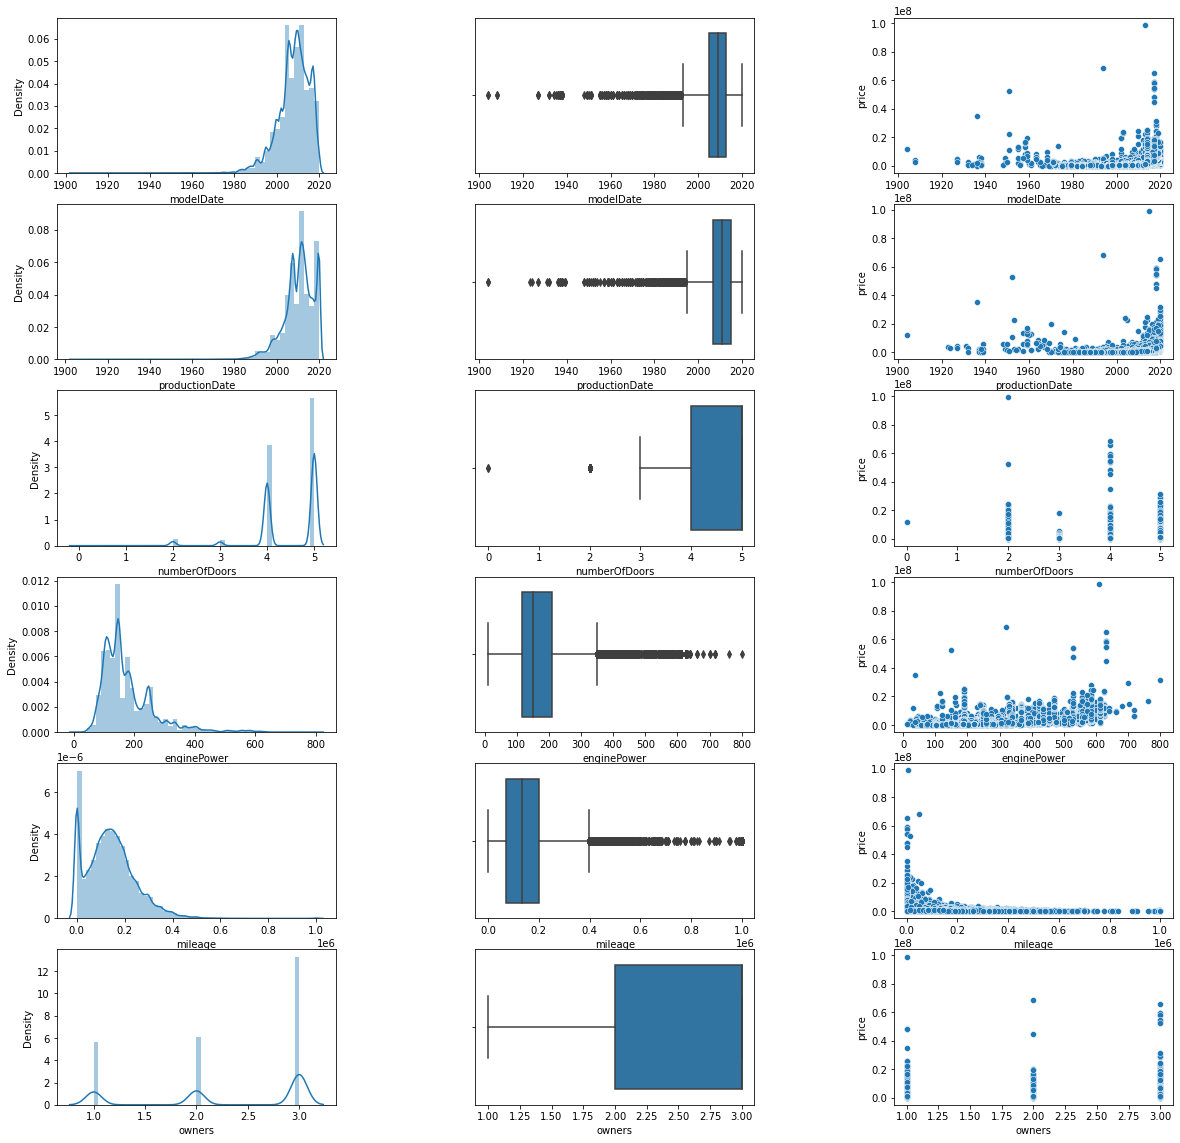

In [108]:
# Построим распределение числовых признаков^

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(6, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(df[col], ax=axes[i])
    i = i + 1
    sns.boxplot(df[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=df[df['sample'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1

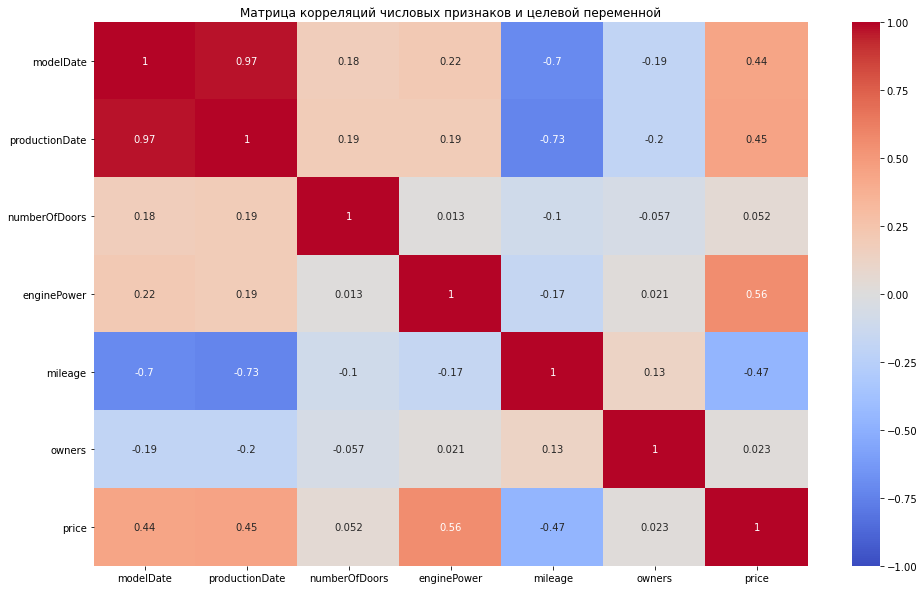

In [109]:
# Построим матрицу корреляций для числовых признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[df['sample'] == 1][num_cols+target_col].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых признаков и целевой переменной')
plt.show()

Оценка важности числовых признаков на целевую переменную


<AxesSubplot:>

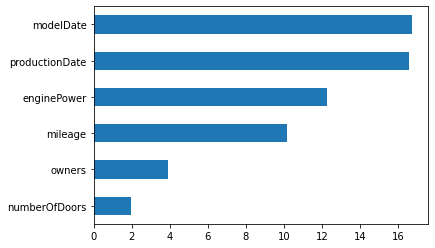

In [110]:
print('Оценка важности числовых признаков на целевую переменную')
imp_num = pd.Series(f_classif(
    df[df['sample'] == 1][num_cols], df[df['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Выводы:

4 из шести признаков имеют практически нормальное распределение со смещением. Новых автомобилей больше, чем старых.

Большиинство автомобилей с пробегом больше 100, тыс км, которыми вдадели не менее трех человек.

Год выпуска марки и год производства авто сильно коррелируют друг с другом, но удалять пока ничего не будем.

Нулевые значения есть только в пробеге и количестве дверей(это старый автомобиль 1904 года).

Все числовые признаки кооррелируют с целевой переменной, поэтому оставляем все как есть.

Два признака (Количество дверей и Владельцы) лучше перевести в категориальные

In [111]:
num_cols.remove('owners')
cat_cols.append('owners')
num_cols.remove('numberOfDoors')
cat_cols.append('numberOfDoors')

In [112]:
print(num_cols)
print(cat_cols)

['modelDate', 'productionDate', 'enginePower', 'mileage']
['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'driveUnit', 'owners', 'numberOfDoors']


#### КАТЕГОРИАЛЬНЫЕ И БИНАРНЫЕ ПЕРЕМЕННЫЕ

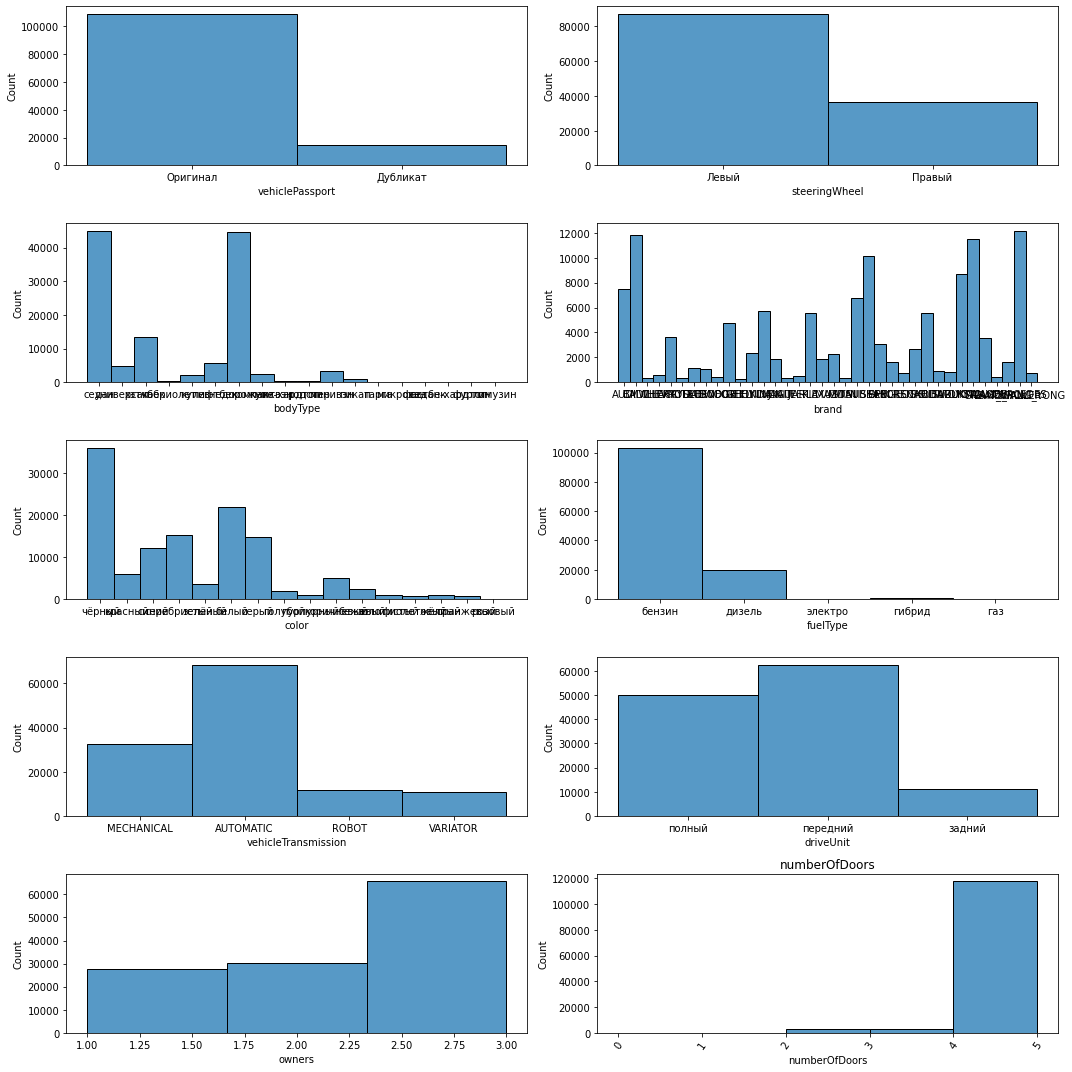

In [113]:
# Построим распределение основных бинарных и категориальных признаков
# не беря в расчет признаки с большим количеством категорий:

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=1.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(data=df, x=df[col], ax=axes[i],
                 stat='count', bins=df[col].nunique())
    plt.tight_layout()
    plt.xticks(rotation=55)
    plt.title(col)
    i = i + 1

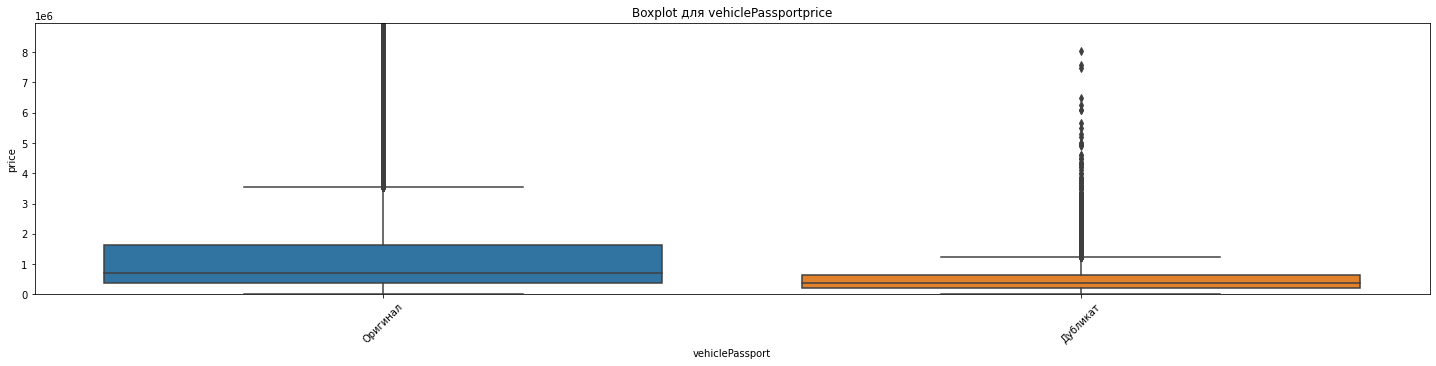

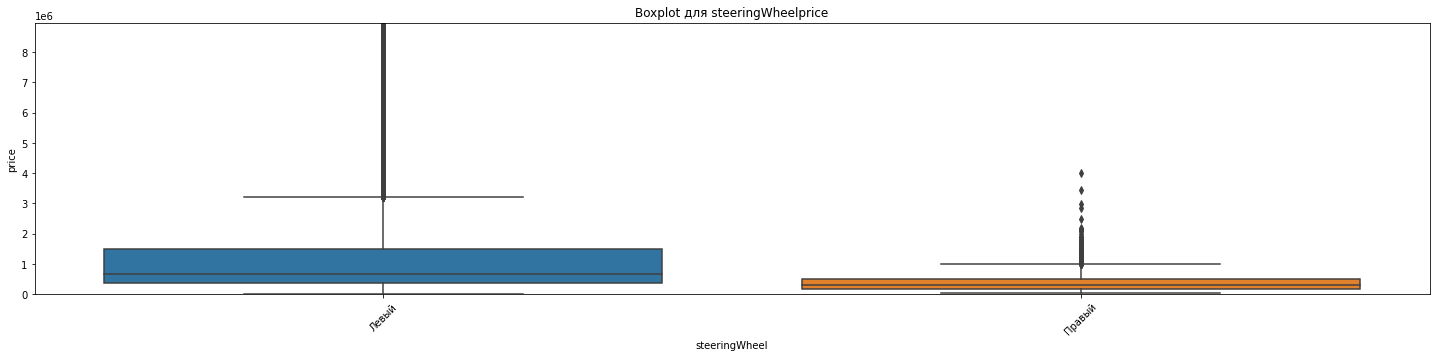

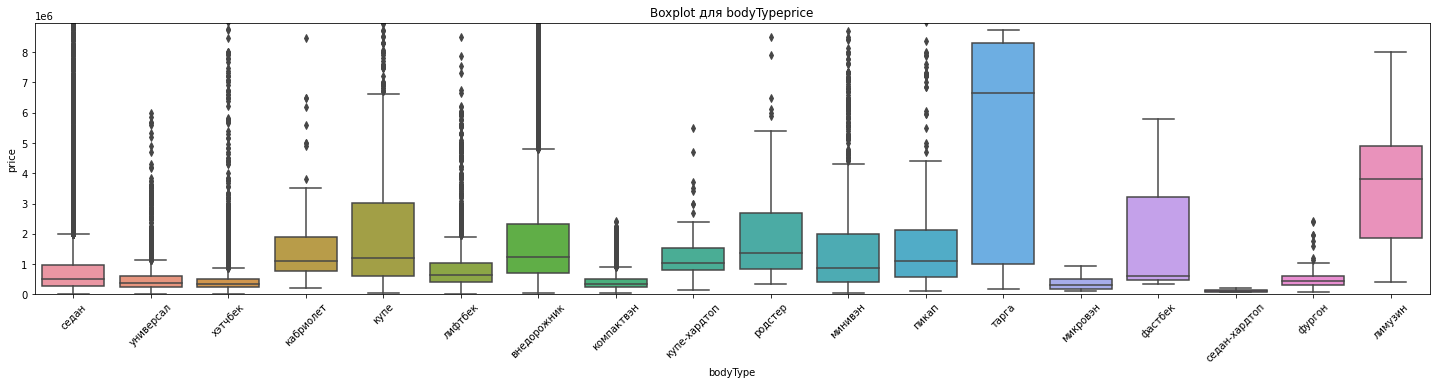

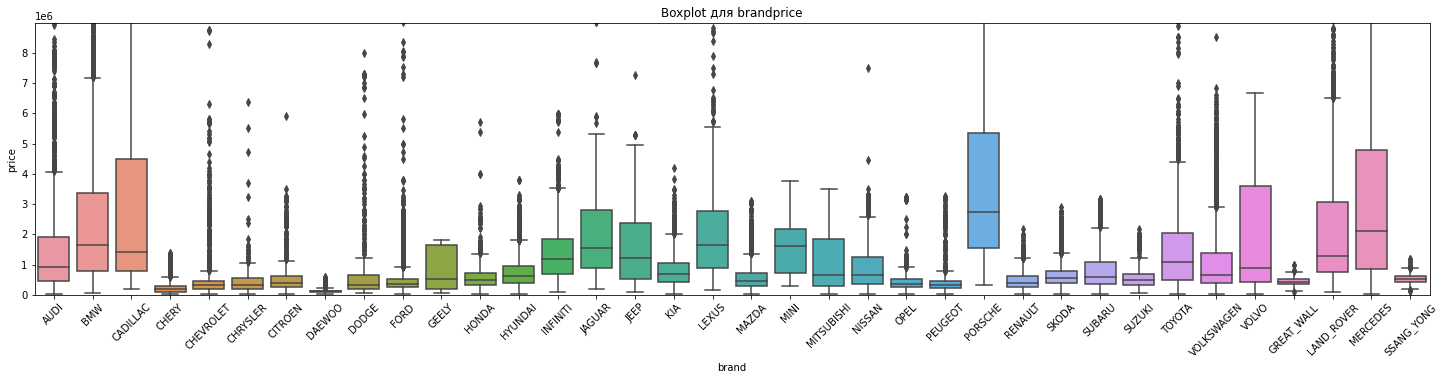

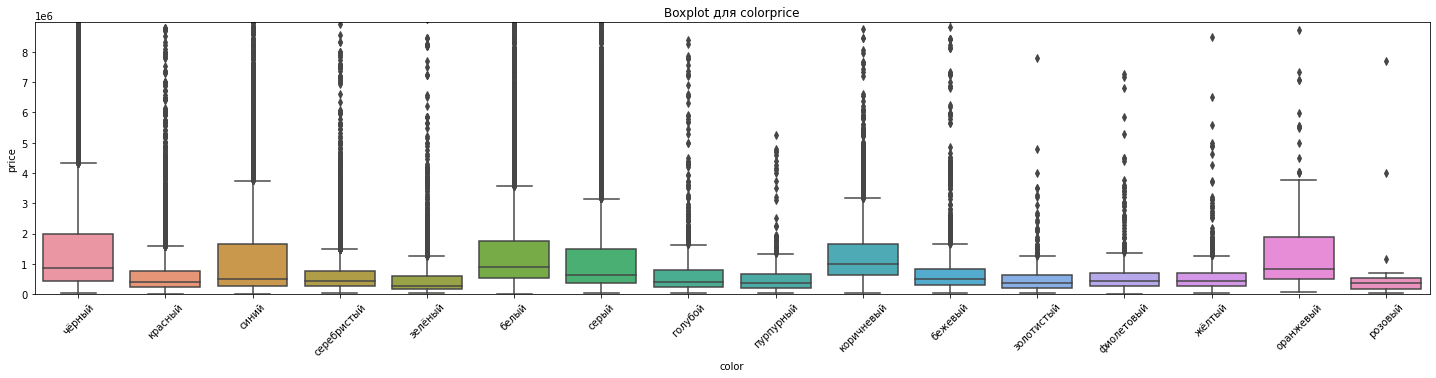

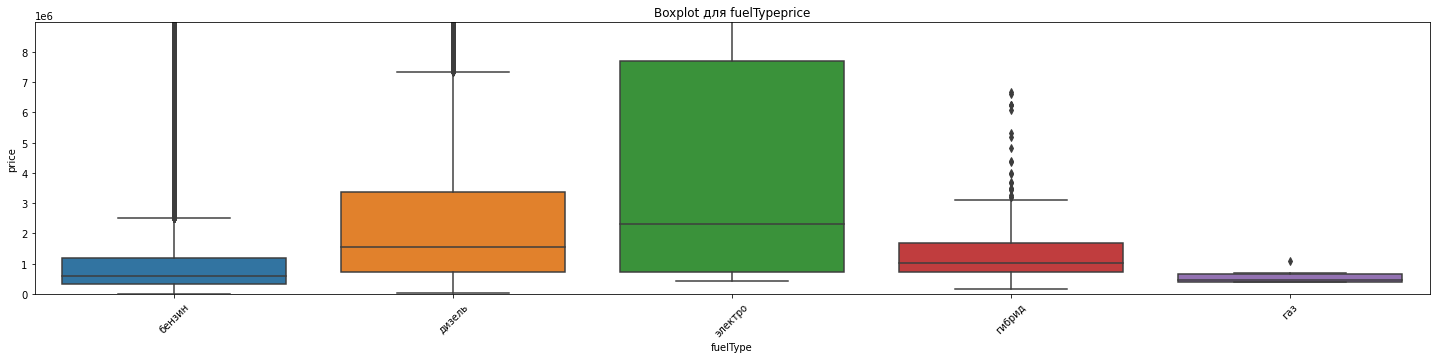

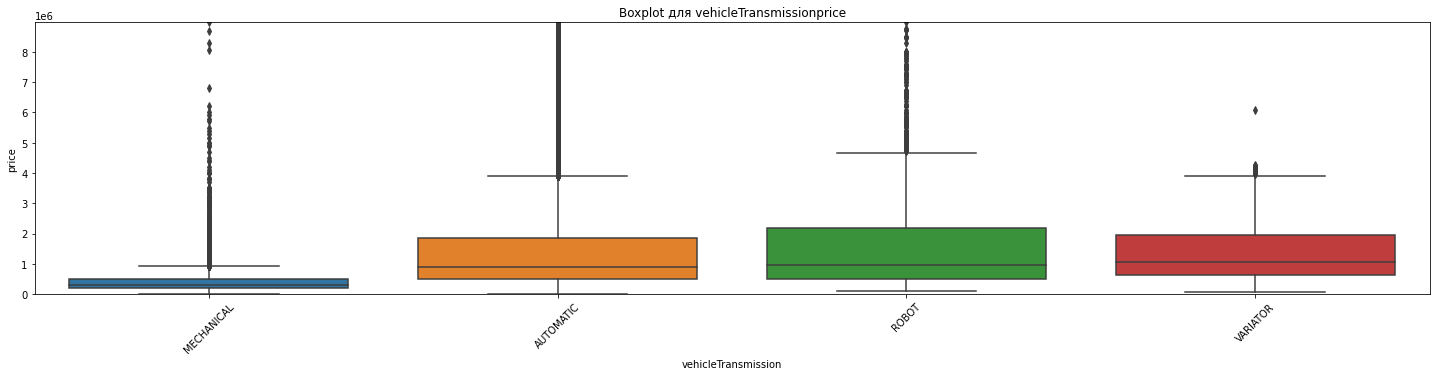

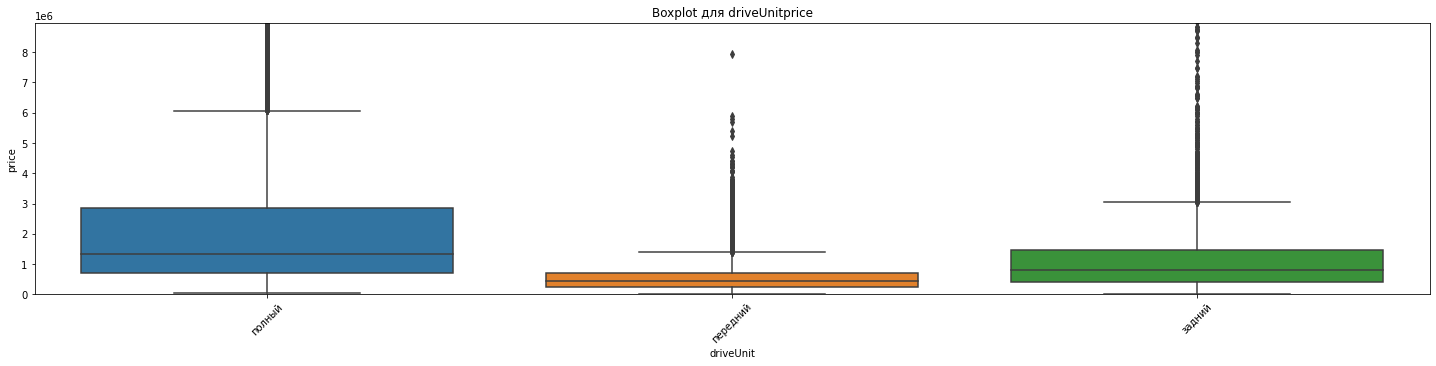

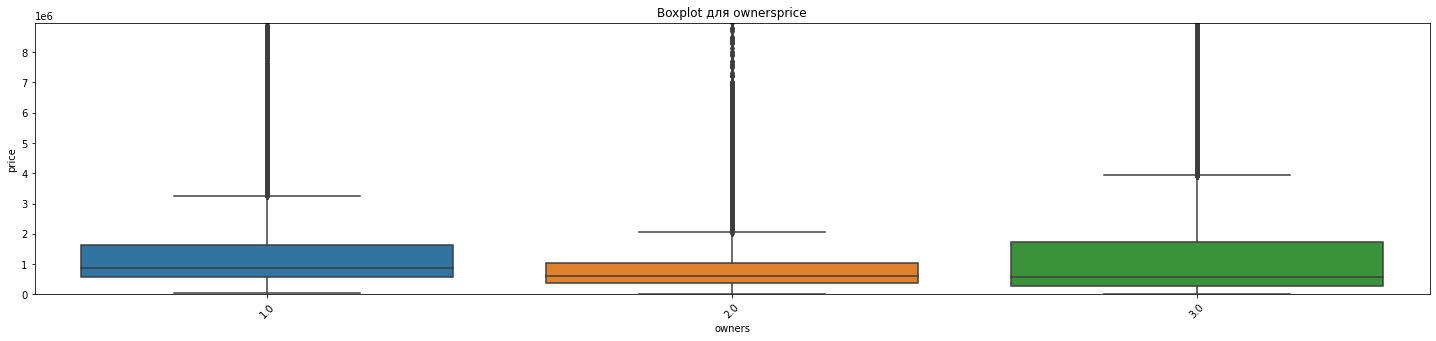

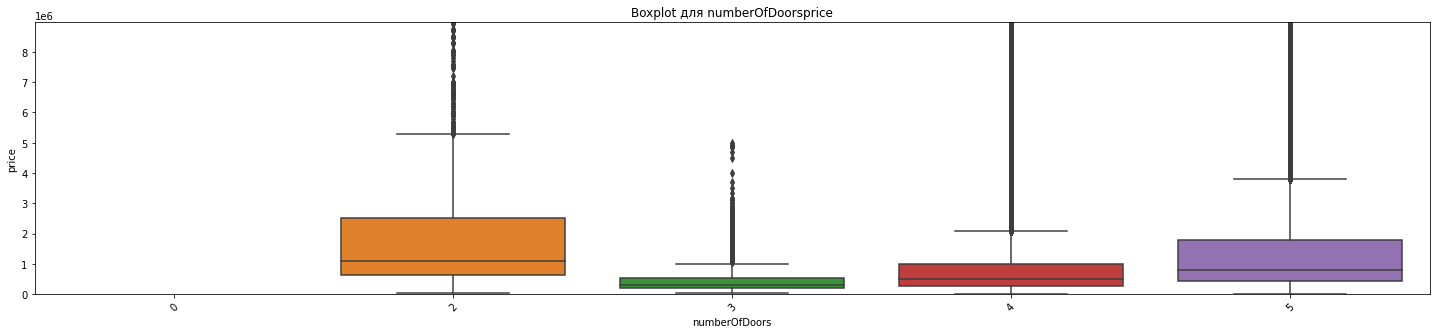

In [114]:
# построим боксплоты для бинарных и категориальных признаков: 
for col in (bin_cols + cat_cols):    
    get_boxplot(col)

#### Выводы: 

Относительно сбалансировнные признаки: owners, vohicleTransmission, driveUnit. Превалируют авто с количеством владельцев 3, с автоматической кобобкой передач и с передним либо полным приводом. По отношению к цене: самые дорогие машины с полным приводом, минимальным количеством владельцев, коробкой передач ROBOT.

Плохо сбалансированные признаки:

vehiclePassport - авто в основном с оригиналом ПТС и цена таких машин выше

steeringWheel - леворульных машин больше и они дороже праворульных

brand - 4 марки (MERCEDES ,BMW, VOLKSWAGEN, NISSAN) составляют больше 30 % от числа всех остальных брендов, из которых к самым догорим относится только MERCEDES. 

bodyType - много видов кузова, превалирют "седан" и "внедорожник", по цене самые дорогие лимузин и тарга, но их количество не превышает 20 единиц.

color - из 16 цветов самый распространенный черный, за ним идут белый, серебристый, серый и синий. К самым дорогим цветам оносятся черний, синий, белый , коричневый и оранженый.

fuelType - тип топлива превалирует -бензин, но самые дорогие авто с электродвигателем, хотя и х количество минимально.

numberOfDoors - в осном две авто пятидверные, по дороговизне они занимают второе место после двухдверных.



### Анализ целевой переменной (price)

In [115]:
df.price[df['sample'] == 1].describe()

count    8.896700e+04
mean     1.294600e+06
std      1.950417e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.500000e+05
75%      1.480000e+06
max      9.900000e+07
Name: price, dtype: float64

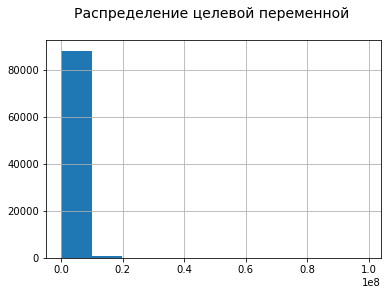

In [116]:
# посмотрим на распределение целевой переменной:
df.query('sample == 1').price.hist();
plt.title("Распределение целевой переменной \n", fontdict={'fontsize': 14});
plt.show()

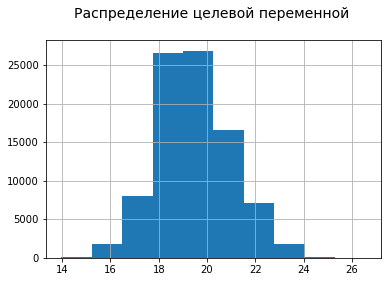

In [117]:
np.log2(df.query('sample == 1').price).hist()
plt.title('Распределение целевой переменной \n', fontdict={'fontsize': 14})

# добавили новый признак в датасет:
df['price_log'] = np.log2(df.price)

После логарифмирвания целевая переменная имеет распределение приближенное к нормальному.

## Работа с выбросами

In [118]:
# Проанализируем выбросы для числовых признаков
print("Отчет о наличии выбросов.\n")
for col in (num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_test(df[col])
    print("-" * 100)

Отчет о наличии выбросов.


Признак:  modelDate

25-й перцентиль: 2005.0, 
75-й перцентиль: 2013.0, 
IQR: 8.0,  
Границы выбросов: [1993.0, 2025.0]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака: Количество: 4435, 3.59%
----------------------------------------------------------------------------------------------------

Признак:  productionDate

25-й перцентиль: 2007.0, 
75-й перцентиль: 2015.0, 
IQR: 8.0,  
Границы выбросов: [1995.0, 2027.0]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака: Количество: 3626, 2.93%
----------------------------------------------------------------------------------------------------

Признак:  enginePower

25-й перцентиль: 117.0, 
75-й перцентиль: 210.0, 
IQR: 93.0,  
Границы выбросов: [-22.5, 349.5]. 

Минимальное значение признака: 11. 
Максимальное значение признака: 800 .

Найдены выбросы по верхней г

Выбросов не так много и они похожи на реальные данные. Например, раритетный автомобиль без дверей, который может стоить очень дорого. Самые большие выбросы присутствуют в целевой переменной. Но избавляться от них не будем.

##  Feature Engineering

In [119]:
#Создадим числовой столбец возраст ('age'). С учетом того, что все даные взяты в 2020 году от него и будем отталкиваться:
df['age']= 2020-df.productionDate

In [120]:
df.age[(df.age<10)].value_counts()

0    12763
8     9401
9     8740
7     8068
6     6658
5     4897
3     4775
4     4615
2     4303
1     3935
Name: age, dtype: int64

In [121]:
# На его основе сделаем бинарный признак для автомобилей с возрастом 10 лет и старше (0 - моложе 10 лет):
df['age_old'] = df.age.apply(lambda x: 0 if x<10 else 1)

In [122]:
df.age_old.value_counts()

0    68155
1    55498
Name: age_old, dtype: int64

In [123]:
# Создадим аналогичный признак по пробегу больше 120000 км (примерно половина выборки), где 0-авто с меньшим пробегом:
print(df.mileage[(df.mileage > 120000)].value_counts().sum())
df['mileage_120000'] = df.mileage.apply(lambda x: 1 if x > 120000 else 0)

69340


In [124]:
df.mileage_120000.value_counts()

1    69340
0    54313
Name: mileage_120000, dtype: int64

In [125]:
# добавим новые признаки в бинарные переменные:
bin_cols.append('age_old')
bin_cols.append('mileage_120000')

In [126]:
bin_cols

['vehiclePassport', 'steeringWheel', 'age_old', 'mileage_120000']

In [127]:
# избавимся от буквенных значений в бинарных признакаx:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [128]:
df[bin_cols].sample(5)

,vehiclePassport,steeringWheel,age_old,mileage_120000
57107,1,0,0,0
94331,1,1,1,1
80675,1,0,1,1
19733,1,0,1,1
117779,1,1,1,1


In [129]:
# применяем Labels encoding к категориальным признакам c большим количеством категорий:
for col in cat_cols_many:
    df[col] = df[col].astype('category').cat.codes 

In [130]:
df[cat_cols_many]

,name,model_name
0,2245,1
1,844,1
2,1703,1
3,844,1
4,1266,1
...,...,...
124059,3072,45
124060,3752,60
124061,3764,60
124062,2361,1053


In [131]:
# закодируем остальные категоральные переменные:
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes 

In [132]:
df[cat_cols]

,bodyType,brand,color,fuelType,vehicleTransmission,driveUnit,owners,numberOfDoors
0,11,0,15,0,1,2,2,3
1,11,0,7,0,1,1,2,3
2,14,0,13,0,1,2,2,4
3,11,0,11,0,1,1,2,3
4,11,0,15,0,1,1,2,3
...,...,...,...,...,...,...,...,...
124059,11,1,6,0,0,0,2,3
124060,11,1,15,3,0,2,0,3
124061,11,1,12,0,0,0,2,3
124062,0,1,6,3,0,2,1,4


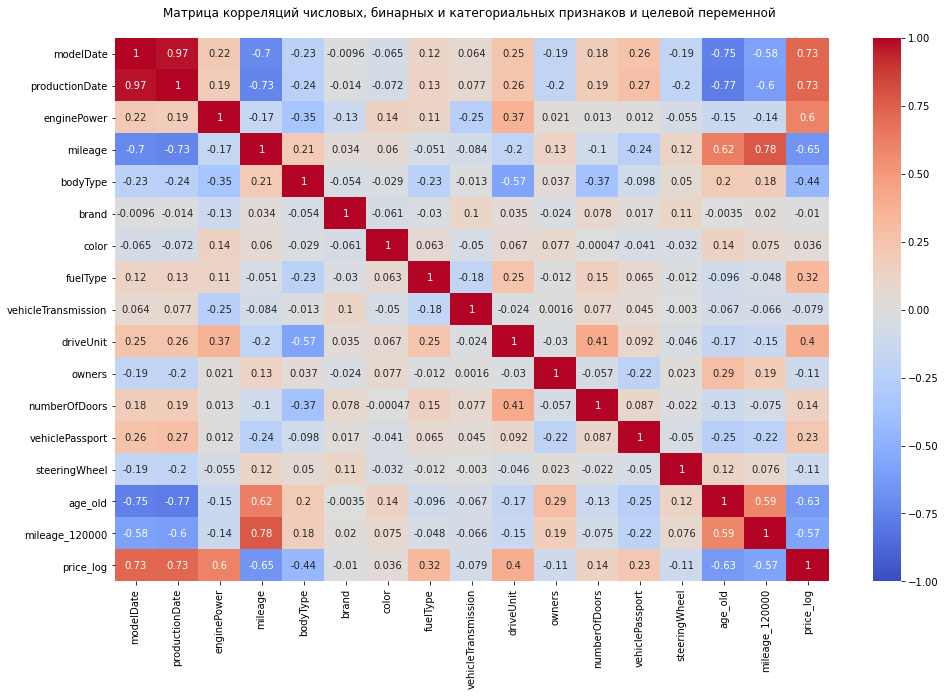

In [133]:
# Построим матрицу корреляций для числовых, бинарных и категориальных признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[df['sample'] == 1][num_cols+cat_cols+bin_cols +
                      ['price_log']].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых, бинарных и категориальных признаков и целевой переменной \n')
plt.show()

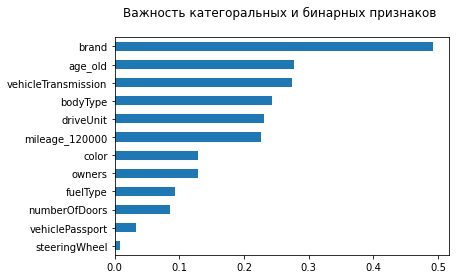

In [134]:
# Теперь посмотрим на важность бинарных и категоральных признаков логарифмированному таргету
imp_cat = pd.Series(
    mutual_info_regression(
        df[df['sample'] == 1][list(set(df.columns) & set(cat_cols+bin_cols))],
        df[df['sample'] == 1]['price_log'],
        discrete_features=True), index=list(set(df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Важность категоральных и бинарных признаков \n')
plt.show()

Корреляция признаков присутствует, но пока не будем ничего удалять. Возможно нам все понадобится.

## Machine Learning

### Split

In [135]:
# Создадим первое разделение для наивной модели:
X = df.query('sample == 1').drop(['sample', 'sell_id','price', 'price_log'], axis=1)
X_sub = df.query('sample == 0').drop(['sample', 'sell_id','price','price_log'], axis=1)


In [136]:
y = df.query('sample == 1').price

In [137]:
X.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,model_name,age,age_old,mileage_120000
35831,11,17,1,0,2015,582,3,2016,1,123,124000,1,0,0,1,804,4,0,1
41416,0,20,9,0,2006,1687,4,2007,0,238,259000,2,0,2,1,307,13,1,1
76248,2,34,12,3,2003,1402,4,2004,2,140,156000,1,0,1,1,959,16,1,1


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [139]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

## Модель 1 - Наивная модель

In [140]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 74.50%


## Модель 2 - CatBoost

Модель CatBoostRegressor хорошо работает с категориальными признаками, числовые признаки надо прологарифмировать для использования.Параметры для этой модели были взяты из Baseline.

In [141]:
# Применим логарифмирование ко всем числовым признакам
for col in num_cols:
    df[col] = df[col].apply(lambda w: np.log(w+1))

In [142]:
df[num_cols]

,modelDate,productionDate,enginePower,mileage
0,7.596392,7.596894,5.164786,12.765691
1,7.592366,7.594381,4.510860,12.063501
2,7.595387,7.595890,4.919981,12.345839
3,7.595387,7.595890,4.510860,12.388398
4,7.596392,7.596894,4.624973,12.611541
...,...,...,...,...
124059,7.606885,7.608374,4.919981,11.652696
124060,7.609367,7.610358,5.252273,11.492733
124061,7.598900,7.599902,5.141664,12.793862
124062,7.607381,7.607878,5.220356,11.413116


In [143]:
X_2_1 = df.query('sample == 1')[cat_cols + bin_cols+num_cols + cat_cols_many]
X_sub_2_1 = df.query('sample == 0')[cat_cols + bin_cols+num_cols + cat_cols_many]

In [144]:
X_2_1

,bodyType,brand,color,fuelType,vehicleTransmission,driveUnit,owners,numberOfDoors,vehiclePassport,steeringWheel,age_old,mileage_120000,modelDate,productionDate,enginePower,mileage,name,model_name
0,11,0,15,0,1,2,2,3,1,0,1,1,7.596392,7.596894,5.164786,12.765691,2245,1
1,11,0,7,0,1,1,2,3,1,0,1,1,7.592366,7.594381,4.510860,12.063501,844,1
2,14,0,13,0,1,2,2,4,1,0,1,1,7.595387,7.595890,4.919981,12.345839,1703,1
3,11,0,11,0,1,1,2,3,1,0,1,1,7.595387,7.595890,4.510860,12.388398,844,1
4,11,0,15,0,1,1,2,3,0,0,1,1,7.596392,7.596894,4.624973,12.611541,1266,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,8,30,15,3,0,2,2,4,1,0,1,1,7.603399,7.604396,5.099866,12.468441,2196,806
89374,8,30,11,3,0,2,2,4,1,0,1,1,7.603399,7.604894,5.099866,12.611541,2196,806
89375,8,30,15,3,0,2,0,4,1,0,0,1,7.607878,7.608374,5.010635,11.744045,1440,909
89376,8,30,12,3,0,2,2,4,1,0,0,0,7.607878,7.607878,5.010635,11.338584,1440,909


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_2_1, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)


In [146]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [147]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.32%


Результат заметно улучшился. Попробуем другие модели и посмотрим как иработают подели по сравнению с CatBoost 

Разбиение, используемое на второй модели менять не будем.

## Модель 3 RandomForestRegressor

In [148]:
rf = RandomForestRegressor(random_state = RANDOM_SEED)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
rf_log.fit(X_train, np.log(y_train))
rf_log_pred = np.exp(rf_log.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 14.12%
Точность модели по метрике MAPE с логтаргетом: 12.77%


In [149]:
# Подбор гирерпараметров для модели:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(1, 10, num=10)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)

rf_random.fit(X_train, np.log(y_train))
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

Гиперпараметры искала дважды с немного разными сетками, второй вариант дал результат чуть лучше. Но при bootstrap: True

Fitting 3 folds for each of 100 candidates, totalling 300 fits

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': True}

In [150]:
# Обучим модель на лучших гиперпараметрах вариант 1

#best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='log2'
                      , max_depth=None
                      , bootstrap=True)

# best_rfr.fit(X_train, y_train)
best_rfr.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
predict_rfr = np.exp(best_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.53%


In [151]:
# Обучим модель на лучших гиперпараметрах вариант 2

#best_rfr = rf_random.best_estimator_
best_rfr_1 = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=800
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='log2'
                      , max_depth=None
                      , bootstrap=True)

# best_rfr.fit(X_train, y_train)
best_rfr_1.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
predict_rfr = np.exp(best_rfr_1.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.51%


ТОР результат на сабмишн (1 вариант)12,07%

ТОР результат на сабмишн (2 вариант)12,22%

Логарифмирование таргета сильно улучшает показатель MAPE, поэтому в дальнейшем будем использовать только логтаргет. Что касается гиперпарамеров, то они улучшили ситуацию, но не сильно. Результат проверялся на кагле с гиперпараметрами.


## Модель 4 - LGBMRegressor 

In [152]:
from lightgbm import LGBMRegressor

In [153]:
# Запустим модель со стандартными параметрами
lgbm = LGBMRegressor(random_state=RANDOM_SEED)
lgbm.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 14.79%


In [154]:
# Поиск гиперпараметров занимает почти вечность, поэтому здесь шел подбор опытным путем:
lgbm = LGBMRegressor(random_state=RANDOM_SEED, objective='regression', num_iterations=1000,
                         n_estimators=100, learning_rate=0.01, num_leaves=1000, 
                         min_child_samples=3,  colsample_bytree=0.5)
lgbm.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 11.94%


Результат улучшился.

ТОР результат на сабмишен (1 вариант)11,95%

## Модель 5 - XGBRegressor

In [155]:
# Запустим модель с параметрами подобранными вручную:
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.05,
    max_depth=12,
    alpha=1,
    n_estimators=1000,
    #random_state=RANDOM_SEED,
    n_jobs=-1)

xgb.fit(X_train, np.log(y_train))
predict_xgb = np.exp(xgb.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_xgb))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 11.97%


Результат чуть немного улучшился . На ТОП сабмишн 11,92 % (лучше, чем на обучении)

## Модель 6 -Extra Tree Regressor с подбором гиперпараметров

In [157]:
# Запустим модель со стандартными параметрами
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s


Точность модели по метрике MAPE c логтаргетом: 13.30%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [158]:
# Попробуем подобрать гиперпараметры для нашей модели

random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid,
                                n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)
# rf_random.fit(X_train, y_train)
etr_random.fit(X_train, np.log(y_train))
etr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [161]:
# Запустим модель со стандартными параметрами
best_etr = ExtraTreesRegressor(n_estimators = 400,
                               min_samples_split= 2,
                               min_samples_leaf= 1,
                               max_features= 'auto',
                               max_depth= 15,
                               bootstrap= False,
                               random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
best_etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(best_etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


Точность модели по метрике MAPE c логтаргетом: 13.15%


Поиск гиперпараметров не дал сильного улучшения метрики, хотя занял почти 1,5 часа

Топ результат на сабмишн 14,47%, больше, чем на 1 % хуже, чем на трейне. 

Подбор параметров не помог.

## СТЕКИНГ

Попробуем использовать стекинг для построения моделей. В качестве базовых моделей возьмем наиболее успешные: LGBMRegressor, Xgboosting и ExtraTreeRegressor (RandomForestRegressor на Юпитере и каггле не заработал), показавшие наибольший результатна каггле.


## Стекинг:LGBMRegressor, Xgboosting +LinearRegression

In [164]:
import xgboost as xgb

In [163]:
estimators = [('lgbm', LGBMRegressor(random_state=RANDOM_SEED, objective='regression', num_iterations=1000,
                                     n_estimators=100, learning_rate=0.01, num_leaves=1000,
                                     min_child_samples=3,  colsample_bytree=0.5)),
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05,
                                           max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_ensemble_1 = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble_1.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 11.86%


В Юпитере стекинг работал, но на кагле результат появился почти час, поэтому буду пробовать его в последнюю очередь.

ТОП результат на сабмишн 11,75% (это лучший результат проекта).


## Стекинг: Xgboosting, ExtraTreesRegressor+LinearRegression

In [165]:
import xgboost as xgb

In [166]:
estimators = [('etr',ExtraTreesRegressor()),
              ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 11.95%


ТОР результат на сабмишен 12,11%


В результате первый вариант стекинга показал себя лучше всего. На его основе и будем делать окончательный сабмишн.

Интересно, что показатели метрики на обучении практически всегда были ниже, чем на ТОП сабмишн.


## Submission

In [167]:
sample_submission = pd.read_csv('sample_submission.csv')

In [168]:
predict_sub = np.exp(st_ensemble_1.predict(X_sub_2_1))
sample_submission['price'] = predict_sub
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.035315e+05
1,1100549428,8.921416e+05
2,1100658222,8.889591e+05
3,1100937408,7.242072e+05
4,1101037972,7.405023e+05
5,1100912634,7.834066e+05
6,1101228730,6.062949e+05
7,1100165896,4.110675e+05
8,1100768262,1.708954e+06
9,1101218501,7.330079e+05


## Conclusions

Результат получился неплохой (11.75%), с учетом того, что использован был только базовый набор данных. Однако на каггле очень медленно обрабатываются модели, особенно стекинг. 

Для улучшения результата необходимо более тщательно обрабатывать признаки и использовать другие методы кодирования категориальных признаков. Также желательна работа в команде, нехватка времени и мощности сказалась на результате. 

Основная работа шла в юпитере, но даже он не справился с некоторыми видами стекинга, поэтому в проект попало то, что работало в юпитере. 

В целом удалось на практике проработать материал модуля за исключением парсинга и получить неплохой результат с учетом работы в одиночку.
